In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [4]:
def normalize_position_and_rotation_to_previous(nodes, edge_index, y: list[torch.tensor]) -> tuple:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the frame before it, so that the first frame is always [0, 0, 0]
    new_pos = [positions[0] - positions[0]]
    for i in range(1, positions.shape[0]):
        new_pos.append(positions[i] - positions[i - 1])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the frame before it
    new_rot = [R.from_quat(rotations[0]).inv() * R.from_quat(rotations[0])]
    for i in range(1, rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[i - 1]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [5]:
def normalize_position_and_rotation_to_first(nodes, edge_index, y):
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the first frame
    new_pos = []
    for i in range(positions.shape[0]):
        new_pos.append(positions[i] - positions[0])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the first frame
    new_rot =  []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [6]:
from torch_geometric.utils import dropout_edge

def transform_edge_dropout(nodes, edge_index, y, p=0.5):
    edge_index, _ = dropout_edge(edge_index, p)
    return nodes, edge_index, y

In [7]:
def dropout_and_transform(nodes, edge_index, y):
    edge_index, _ = dropout_edge(edge_index, p=0.5)
    return normalize_position_and_rotation_to_first(nodes, edge_index, y)

In [13]:
from dataset import KittiGraphDatasetWithGraphBasedOnVectorDistance
from model import PoseGNN, PoseLoss

BATCH_SIZE = 128
GRAPH_LENGTH = 5

dataset = MultipleSequenceGraphDataset(
    basedir,
    train_sequences,
    # dataset=KittiGraphDatasetWithGraphBasedOnVectorDistance,
    transform=transform_edge_dropout,
    graph_length=GRAPH_LENGTH,
)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss(alpha=10, graph_length=GRAPH_LENGTH, batch_size=BATCH_SIZE).to(
    device
)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
MODEL_LETTER = "LOSS_TEST_B_VECTORIZED_BATCH1"

os.makedirs(f"models/{MODEL_LETTER}", exist_ok=True)

loss_history = []
for epoch in range(1, 151):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
       
    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{epoch}.pth")

torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_final.pth")

Epoch 1:   0%|          | 0/160 [00:00<?, ?it/s, loss=1.34]

Epoch 1: 100%|██████████| 160/160 [00:09<00:00, 17.45it/s, loss=1.09]


Epoch 1 loss: 1.5884046636521816


Epoch 2: 100%|██████████| 160/160 [00:09<00:00, 17.73it/s, loss=1.27]


Epoch 2 loss: 1.5393100567162037


Epoch 3: 100%|██████████| 160/160 [00:09<00:00, 17.73it/s, loss=1.6] 


Epoch 3 loss: 1.5381209924817085


Epoch 4: 100%|██████████| 160/160 [00:08<00:00, 17.82it/s, loss=2.25]


Epoch 4 loss: 1.5401877142488956


Epoch 5: 100%|██████████| 160/160 [00:09<00:00, 17.56it/s, loss=1.87]


Epoch 5 loss: 1.5374906085431577


Epoch 6: 100%|██████████| 160/160 [00:08<00:00, 17.98it/s, loss=1.52]


Epoch 6 loss: 1.5349168583750725


Epoch 7: 100%|██████████| 160/160 [00:09<00:00, 17.45it/s, loss=1.84]


Epoch 7 loss: 1.537609551101923


Epoch 8: 100%|██████████| 160/160 [00:09<00:00, 17.49it/s, loss=1.94]


Epoch 8 loss: 1.537403365969658


Epoch 9: 100%|██████████| 160/160 [00:09<00:00, 17.70it/s, loss=1.27]


Epoch 9 loss: 1.533460510522127


Epoch 10: 100%|██████████| 160/160 [00:09<00:00, 17.53it/s, loss=1.41]


Epoch 10 loss: 1.5340048171579839


Epoch 11: 100%|██████████| 160/160 [00:08<00:00, 17.85it/s, loss=1.6] 


Epoch 11 loss: 1.536365084350109


Epoch 12: 100%|██████████| 160/160 [00:09<00:00, 17.75it/s, loss=1.22]


Epoch 12 loss: 1.5334298320114612


Epoch 13: 100%|██████████| 160/160 [00:09<00:00, 17.65it/s, loss=1.37]


Epoch 13 loss: 1.5338436178863049


Epoch 14: 100%|██████████| 160/160 [00:09<00:00, 17.51it/s, loss=1.14]


Epoch 14 loss: 1.5326012432575227


Epoch 15: 100%|██████████| 160/160 [00:09<00:00, 17.68it/s, loss=2.23]


Epoch 15 loss: 1.5387371063232422


Epoch 16: 100%|██████████| 160/160 [00:08<00:00, 17.81it/s, loss=1.18]


Epoch 16 loss: 1.5328915297985077


Epoch 17: 100%|██████████| 160/160 [00:08<00:00, 17.81it/s, loss=1.14]


Epoch 17 loss: 1.5325381726026535


Epoch 18: 100%|██████████| 160/160 [00:08<00:00, 17.86it/s, loss=2.61]


Epoch 18 loss: 1.5407496608793736


Epoch 19: 100%|██████████| 160/160 [00:08<00:00, 18.03it/s, loss=1.81]


Epoch 19 loss: 1.5361986182630063


Epoch 20: 100%|██████████| 160/160 [00:08<00:00, 17.84it/s, loss=1.32]


Epoch 20 loss: 1.5334402680397035


Epoch 21: 100%|██████████| 160/160 [00:09<00:00, 17.69it/s, loss=1.71]


Epoch 21 loss: 1.5355838753283024


Epoch 22: 100%|██████████| 160/160 [00:09<00:00, 17.74it/s, loss=1.3] 


Epoch 22 loss: 1.5338772729039192


Epoch 23: 100%|██████████| 160/160 [00:09<00:00, 17.71it/s, loss=1.53]


Epoch 23 loss: 1.5347993053495883


Epoch 24: 100%|██████████| 160/160 [00:09<00:00, 17.74it/s, loss=1.42]


Epoch 24 loss: 1.5339903458952904


Epoch 25: 100%|██████████| 160/160 [00:09<00:00, 17.48it/s, loss=1.74]


Epoch 25 loss: 1.5357531011104584


Epoch 26: 100%|██████████| 160/160 [00:09<00:00, 16.73it/s, loss=2.22]


Epoch 26 loss: 1.538545771688223


Epoch 27: 100%|██████████| 160/160 [00:09<00:00, 17.13it/s, loss=2.52]


Epoch 27 loss: 1.5403055474162102


Epoch 28: 100%|██████████| 160/160 [00:09<00:00, 16.38it/s, loss=1.45]


Epoch 28 loss: 1.5408256627619266


Epoch 29: 100%|██████████| 160/160 [00:09<00:00, 17.54it/s, loss=1.88]


Epoch 29 loss: 1.537031901627779


Epoch 30: 100%|██████████| 160/160 [00:09<00:00, 17.37it/s, loss=2.02]


Epoch 30 loss: 1.5374235823750495


Epoch 31: 100%|██████████| 160/160 [00:09<00:00, 17.08it/s, loss=1.67]


Epoch 31 loss: 1.5355452947318553


Epoch 32: 100%|██████████| 160/160 [00:09<00:00, 17.53it/s, loss=1.81]


Epoch 32 loss: 1.5362144872546195


Epoch 33: 100%|██████████| 160/160 [00:08<00:00, 17.92it/s, loss=1.19]


Epoch 33 loss: 1.5327246002852917


Epoch 34: 100%|██████████| 160/160 [00:08<00:00, 17.81it/s, loss=2]   


Epoch 34 loss: 1.5372379921376704


Epoch 35: 100%|██████████| 160/160 [00:09<00:00, 17.30it/s, loss=1.46]


Epoch 35 loss: 1.5341339215636254


Epoch 36: 100%|██████████| 160/160 [00:09<00:00, 17.51it/s, loss=1.4] 


Epoch 36 loss: 1.5338118180632592


Epoch 37: 100%|██████████| 160/160 [00:08<00:00, 17.80it/s, loss=2.28]


Epoch 37 loss: 1.5387390688061715


Epoch 38: 100%|██████████| 160/160 [00:08<00:00, 17.86it/s, loss=1.74]


Epoch 38 loss: 1.5357539176940918


Epoch 39: 100%|██████████| 160/160 [00:08<00:00, 17.94it/s, loss=1.42]


Epoch 39 loss: 1.5340017959475518


Epoch 40: 100%|██████████| 160/160 [00:09<00:00, 17.60it/s, loss=0.939]


Epoch 40 loss: 1.5311872996389866


Epoch 41: 100%|██████████| 160/160 [00:09<00:00, 17.60it/s, loss=2.08]


Epoch 41 loss: 1.537610574811697


Epoch 42: 100%|██████████| 160/160 [00:08<00:00, 17.85it/s, loss=1.89]


Epoch 42 loss: 1.5365846283733844


Epoch 43:  73%|███████▎  | 117/160 [00:06<00:02, 17.24it/s, loss=1.86]


KeyboardInterrupt: 

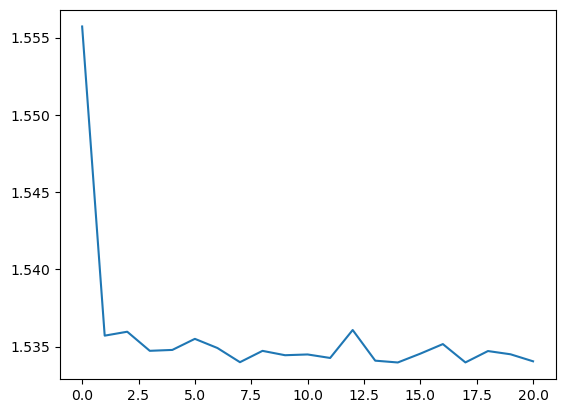

In [ ]:
# plot loss
plt.plot(loss_history)
plt.show()